In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from time import time

# Import The Dataset

In [2]:
df = pd.read_csv("sri_lanka_western_colombo_1_month_rainfall_aggregate_first_period.csv")

In [3]:
# convert the dataset into dataframe
df = pd.DataFrame(df)

In [4]:
# Display first five rows of the datafram
df.head()

,Date,1_month_rainfall_aggregate
0,1/1/1981,NaN
1,11/1/1981,NaN
2,21/1/1981,75.3478
3,1/2/1981,62.2609
4,11/2/1981,62.2609


In [5]:
# Display last five row of the dataset
df.tail()

,Date,1_month_rainfall_aggregate
1549,11/1/2024,221.5217
1550,21/1/2024,182.3913
1551,1/2/2024,54.8261
1552,11/2/2024,47.0000
1553,21/2/2024,41.1739


In [6]:
# Number of row and columns in the dataset
df.shape

(1554, 2)

In [7]:
# Summary statistic of the dataset
df.describe()

,1_month_rainfall_aggregate
count,1552.000000
mean,245.888924
std,158.121216
min,15.521700
25%,125.956550
50%,213.478300
75%,339.717350
max,1019.913000


In [8]:
# Data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        1554 non-null   object 
 1   1_month_rainfall_aggregate  1552 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.4+ KB


# Data Preprocessing

In [9]:
# Calculate the null values count in the each column
df.isnull().sum()

Date                          0
1_month_rainfall_aggregate    2
dtype: int64

In [10]:
# Check what are the null values
df.isnull()

,Date,1_month_rainfall_aggregate
0,False,True
1,False,True
2,False,False
3,False,False
4,False,False
...,...,...
1549,False,False
1550,False,False
1551,False,False
1552,False,False


In [11]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

In [12]:
print(df['Date'].dtype)

datetime64[ns]


In [13]:
df['Date'].head(10)

0   1981-01-01
1   1981-01-11
2   1981-01-21
3   1981-02-01
4   1981-02-11
5   1981-02-21
6   1981-03-01
7   1981-03-11
8   1981-03-21
9   1981-04-01
Name: Date, dtype: datetime64[ns]

In [14]:
# We have to treat that null values, for that we will remove thoes two null values. thoes two values inclued the data at 1981 january
# Therefore, we will remove the all the data which is conclueded to 1981 january.
# Remove data from January 1981
# Remove first 3 rows
df = df.iloc[3:]

In [15]:
print(df.head())

        Date  1_month_rainfall_aggregate
3 1981-02-01                     62.2609
4 1981-02-11                     62.2609
5 1981-02-21                     69.6522
6 1981-03-01                     36.7391
7 1981-03-11                     47.0000


In [16]:
# Check again if there is null values
df.isnull().sum()

Date                          0
1_month_rainfall_aggregate    0
dtype: int64

In [17]:
# Check if there is duplication values.
df.duplicated().sum()

0

In [18]:
# Set 'Date' column as the index
df.set_index('Date', inplace=True)

In [19]:
print(df.head())
print(df.dtypes)

            1_month_rainfall_aggregate
Date                                  
1981-02-01                     62.2609
1981-02-11                     62.2609
1981-02-21                     69.6522
1981-03-01                     36.7391
1981-03-11                     47.0000
1_month_rainfall_aggregate    float64
dtype: object


In [20]:
# convert the data type of the 1_month_rainfall_aggregate column in to float
df['1_month_rainfall_aggregate'] = df['1_month_rainfall_aggregate'].astype(float)

# EDA

Text(0.5, 0, 'Date')

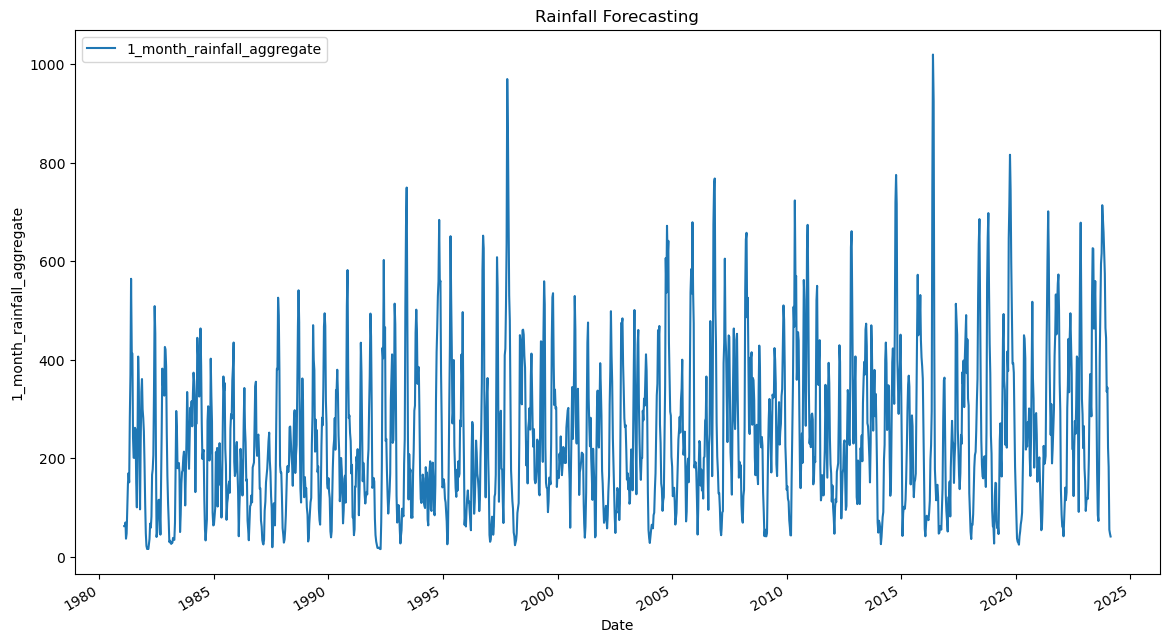

In [21]:
df.plot(kind='line',figsize=(14,8))
plt.title("Rainfall Forecasting")
plt.ylabel("1_month_rainfall_aggregate")
plt.xlabel("Date")

<Axes: xlabel='Date'>

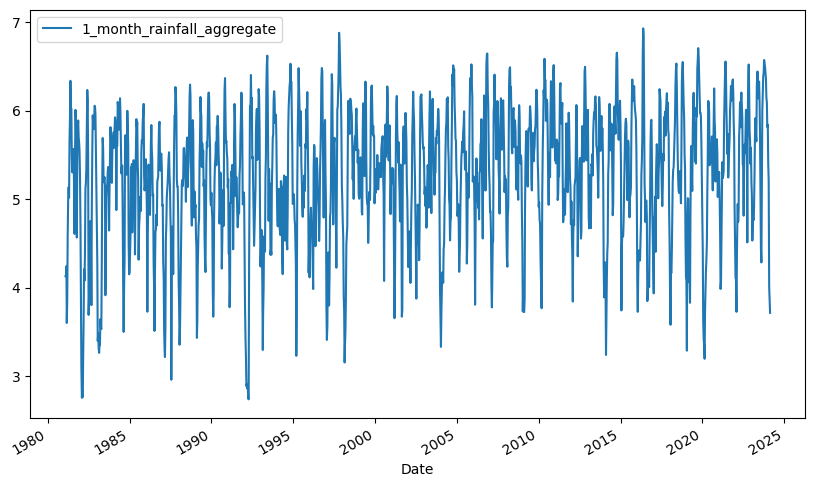

In [22]:
# Transform the series using logarithm
df = np.log(df)
df.plot()

In [23]:
# Does not look like it has a trend that mean it is more like to be stationary

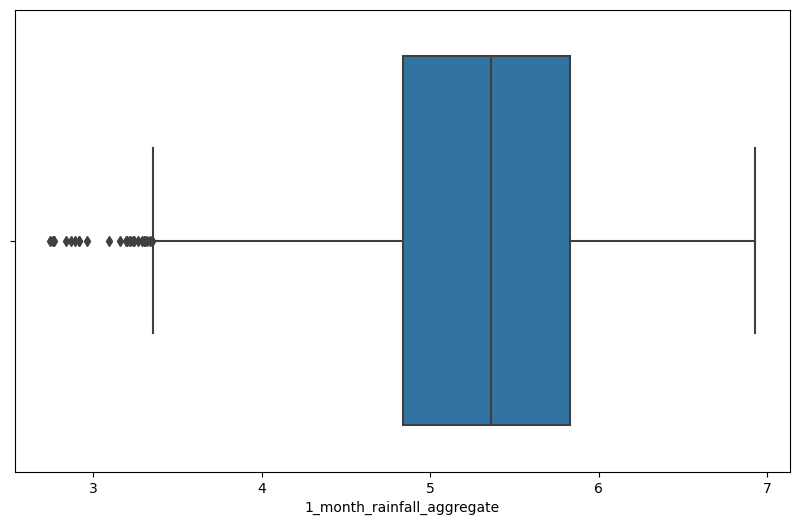

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot for 'Avg Salary Estimate'
sns.boxplot(x=df['1_month_rainfall_aggregate'])
plt.show()

In [25]:
Q1 = df['1_month_rainfall_aggregate'].quantile(0.25)
Q3 = df['1_month_rainfall_aggregate'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((df['1_month_rainfall_aggregate'] < Q1 - 1.5 * IQR) | (df['1_month_rainfall_aggregate'] > Q3 + 1.5 * IQR))


In [26]:
# Count the number of outliers.
outliers.sum()

26

In [27]:
# Remove outliers and create a new DataFrame
df = df[~outliers]

In [28]:
import pmdarima as pm

In [29]:
df 

,1_month_rainfall_aggregate
Date,
1981-02-01,4.131334
1981-02-11,4.131334
1981-02-21,4.243514
1981-03-01,3.603842
1981-03-11,3.850148
...,...
2024-01-11,5.400521
2024-01-21,5.206154
2024-02-01,4.004166


In [30]:
# Reset 'Date' column from the index
df.reset_index(inplace=True)

In [31]:
# Separate features and target variable
x = df['Date']
y = df['1_month_rainfall_aggregate']

In [32]:
# Sort by date
df.sort_values(by='Date', inplace=True)

# Split into train and test (80% train, 20% test)
train_size = int(0.8 * len(df))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print train and test sets
print("Train set:")
print(x_train)
print("\nTest set:")
print(x_test)

Train set:
0      1981-02-01
1      1981-02-11
2      1981-02-21
3      1981-03-01
4      1981-03-11
          ...    
1215   2015-06-21
1216   2015-07-01
1217   2015-07-11
1218   2015-07-21
1219   2015-08-01
Name: Date, Length: 1220, dtype: datetime64[ns]

Test set:
1220   2015-08-11
1221   2015-08-21
1222   2015-09-01
1223   2015-09-11
1224   2015-09-21
          ...    
1520   2024-01-11
1521   2024-01-21
1522   2024-02-01
1523   2024-02-11
1524   2024-02-21
Name: Date, Length: 305, dtype: datetime64[ns]


C:\Users\acer\AppData\Local\Temp\ipykernel_12572\4120608392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='Date', inplace=True)


print(x)

# Step1: Check the stationarity of time series
## Method1: time series plot
## Method2: ACF plot and PACF plot

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

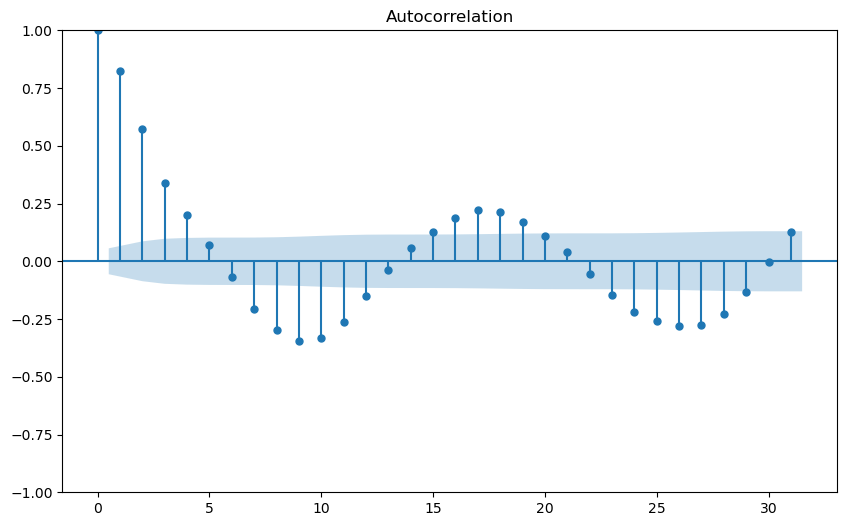

In [34]:
acf_original = plot_acf(y_train)

In [35]:
# acf plot drops in value more quickly the time series less correlated its lag

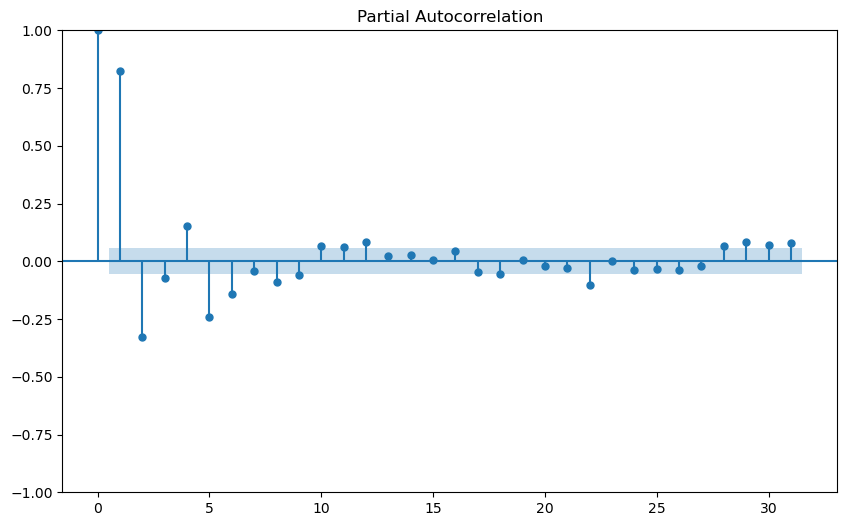

In [36]:
pacf_original = plot_pacf(y_train)

In [37]:
# pacf plot also shows a less strong spike at lag one it is a signs of the series is stationary

In [38]:
# from above plot shows that our dataset is stationarty

In [39]:
# let do the ADF test check again if our dataset the stationr or not
from statsmodels.tsa.stattools import adfuller
adf_test =adfuller(y_train)
print(f"p-value: {adf_test[1]}") 

p-value: 3.1257939369931976e-13


In [40]:
# p-value is very small that means enough to reject null hypothesis at a 5% significant level, meaning the time series is stationanry

In [41]:
# our dataset already stationary therefore we do not need to to differencing 

# Step2: Determine ARIMA models parameters p,q

In [42]:
# d is zero, p is two, q is zero.

# Step3: Fit the ARIMA model

In [43]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=(2,0,0))
model_fit=model.fit()
print(model_fit.summary())

                                   SARIMAX Results                                    
Dep. Variable:     1_month_rainfall_aggregate   No. Observations:                 1220
Model:                         ARIMA(2, 0, 0)   Log Likelihood                -492.712
Date:                        Tue, 07 May 2024   AIC                            993.425
Time:                                06:33:56   BIC                           1013.851
Sample:                                     0   HQIC                          1001.113
                                       - 1220                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2772      0.050    104.997      0.000       5.179       5.376
ar.L1          1.0983      0.028     39.890      0.000       1.044 

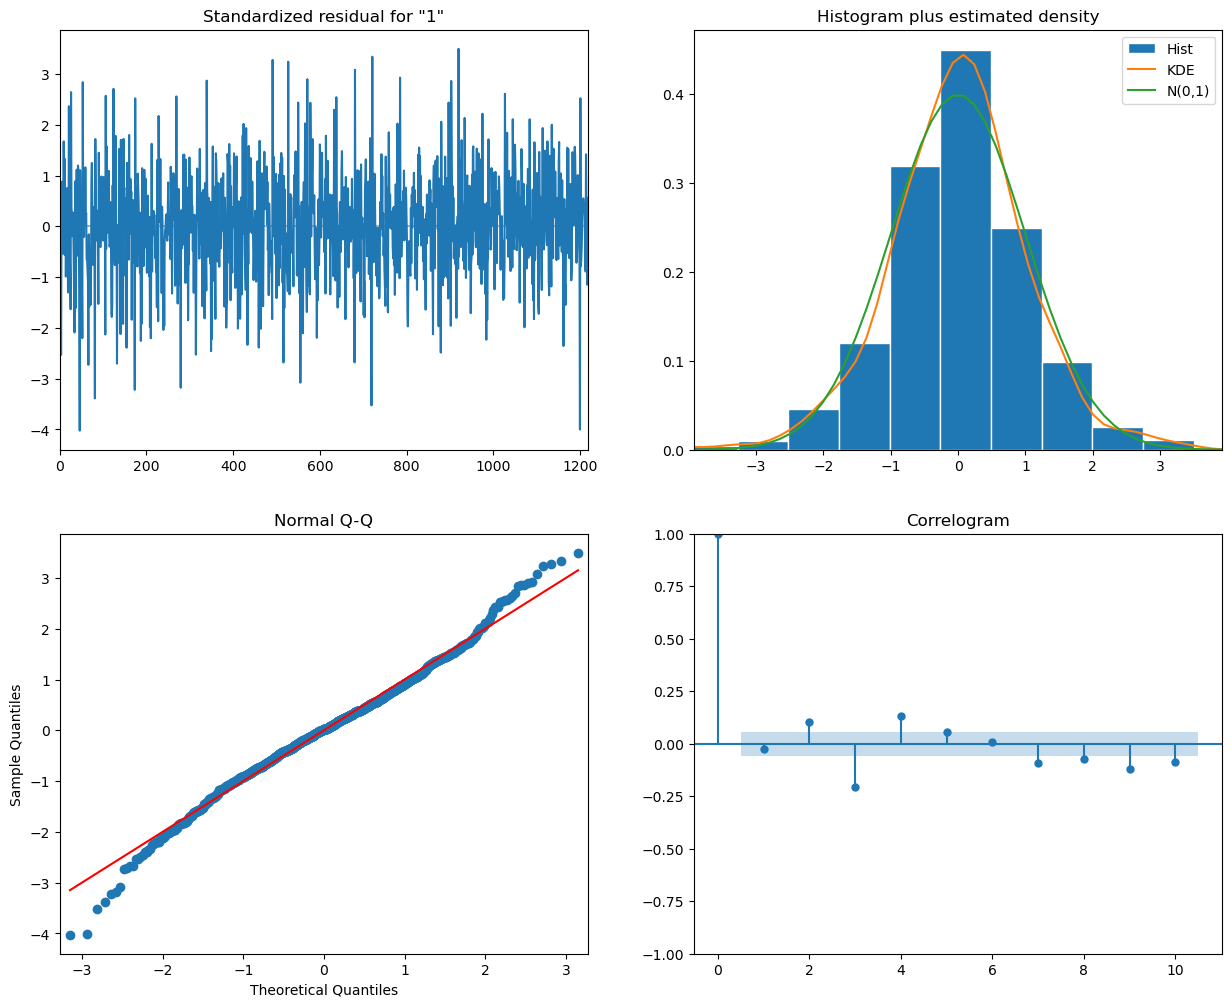

In [44]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

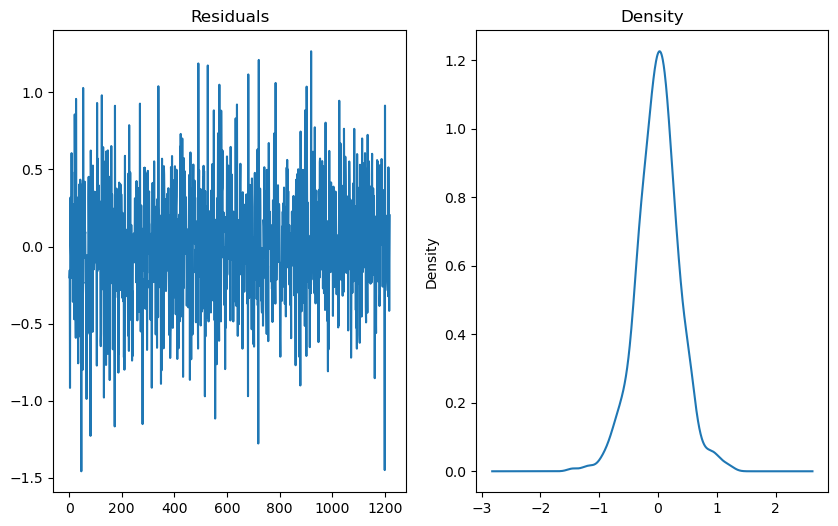

In [45]:
residuals = model_fit.resid[1:]
fig,ax = plt.subplots(1,2)
residuals.plot(title='Residuals' , ax=ax[0])
residuals.plot(title='Density' ,kind='kde' , ax=ax[1])
plt.show()

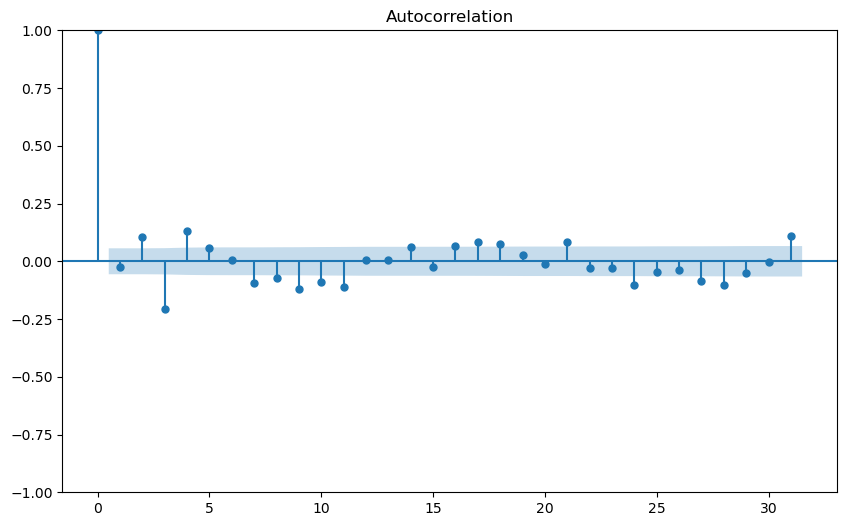

In [46]:
acf_res = plot_acf(residuals)

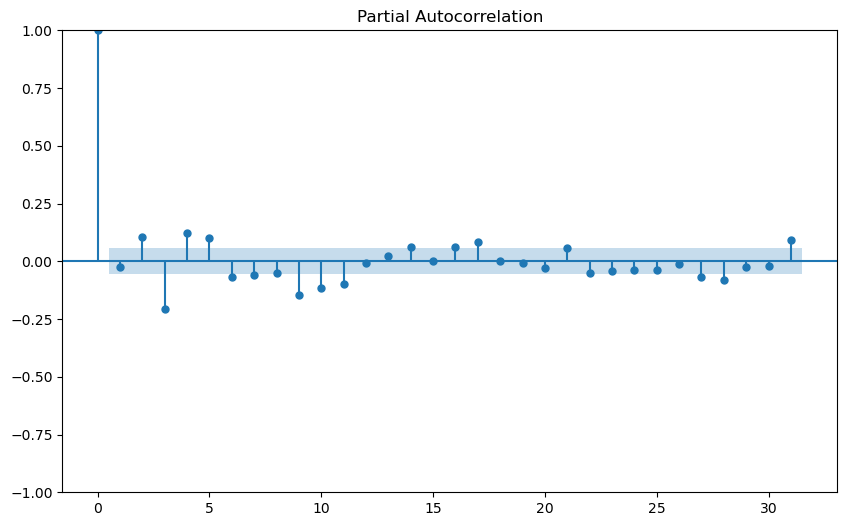

In [47]:
pacf_res =plot_pacf(residuals)

In [48]:
# Thoes graph show the residuals are close to white noise

In [49]:
forecast_test = model_fit.forecast(len(y_test))
df['Forecast_manual'] =[None]*len(y_train) + list(forecast_test)

In [50]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(forecast_test))

Length of y_test: 305
Length of y_pred: 305


In [51]:
# Create a DataFrame with x_test and y_pred values
df_pred = pd.DataFrame({'Date': x_test, 'Actual': y_test, 'Predicted': forecast_test})
print(df_pred)

           Date    Actual  Predicted
1220 2015-08-11  5.053473   5.154115
1221 2015-08-21  5.129641   5.226771
1222 2015-09-01  5.799224   5.262445
1223 2015-09-11  6.123255   5.277642
1224 2015-09-21  6.350355   5.282557
...         ...       ...        ...
1520 2024-01-11  5.400521   5.277203
1521 2024-01-21  5.206154   5.277203
1522 2024-02-01  4.004166   5.277203
1523 2024-02-11  3.850148   5.277203
1524 2024-02-21  3.717805   5.277203

[305 rows x 3 columns]


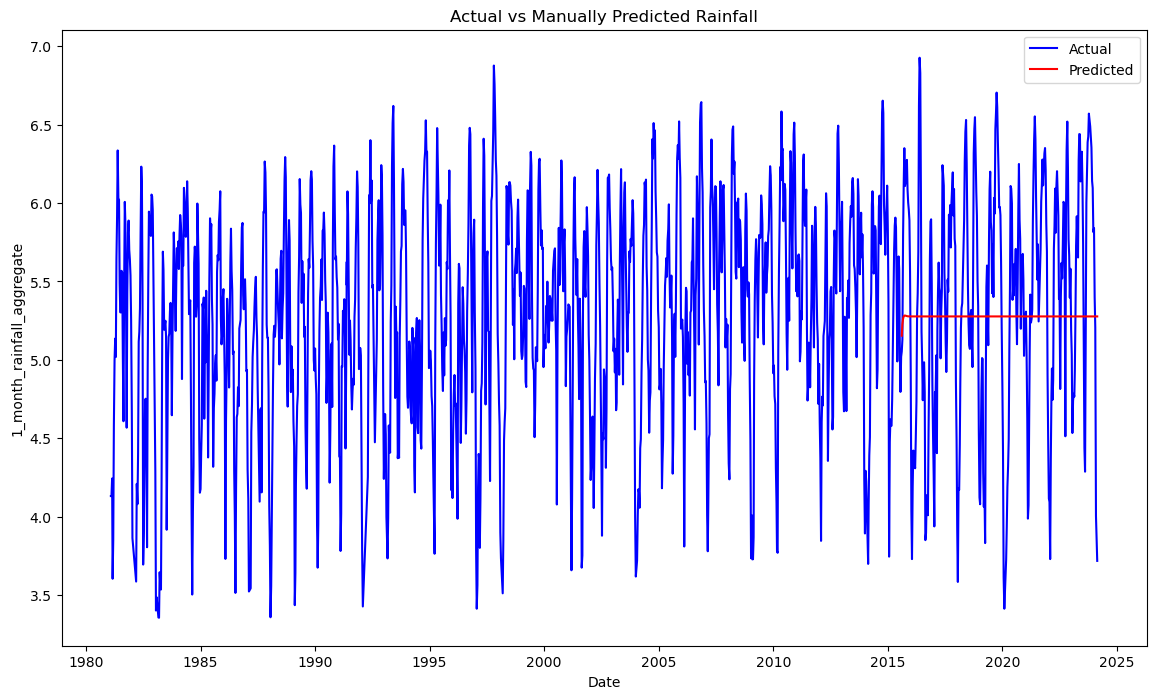

In [52]:
# Plot actual and predicted values
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], df['1_month_rainfall_aggregate'], label='Actual', color='blue')
plt.plot(df_pred['Date'], df_pred['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('1_month_rainfall_aggregate')
plt.title('Actual vs Manually Predicted Rainfall')
plt.legend()
plt.show()

# Use ARIMA Automated Model

In [53]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(y_train,
                      start_p=2,
                      start_q=2,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [54]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1220
Model:               SARIMAX(5, 0, 1)   Log Likelihood                -420.403
Date:                Tue, 07 May 2024   AIC                            856.806
Time:                        06:34:26   BIC                            897.658
Sample:                             0   HQIC                           872.182
                               - 1220                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9031      0.106      8.505      0.000       0.695       1.111
ar.L1          1.5834      0.072     22.057      0.000       1.443       1.724
ar.L2         -0.7687      0.089     -8.683      0.000      -0.942      -0.595
ar.L3         -0.2076      0.062     -3.363      0.001      -0.329      -0.087
ar.L4          0.5563      0.054     10.244      0.000       0.450       0.663
ar.L5         -0.3346      0.029    -11.380      0.000      -0.392      -0.277
ma.L1         -0.5003      0.073     -6.878      0.000      -0.643      -0.358
sigma2         0.1163      0.004     30.153      0.000       0.109       0.124
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                73.94
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.04
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

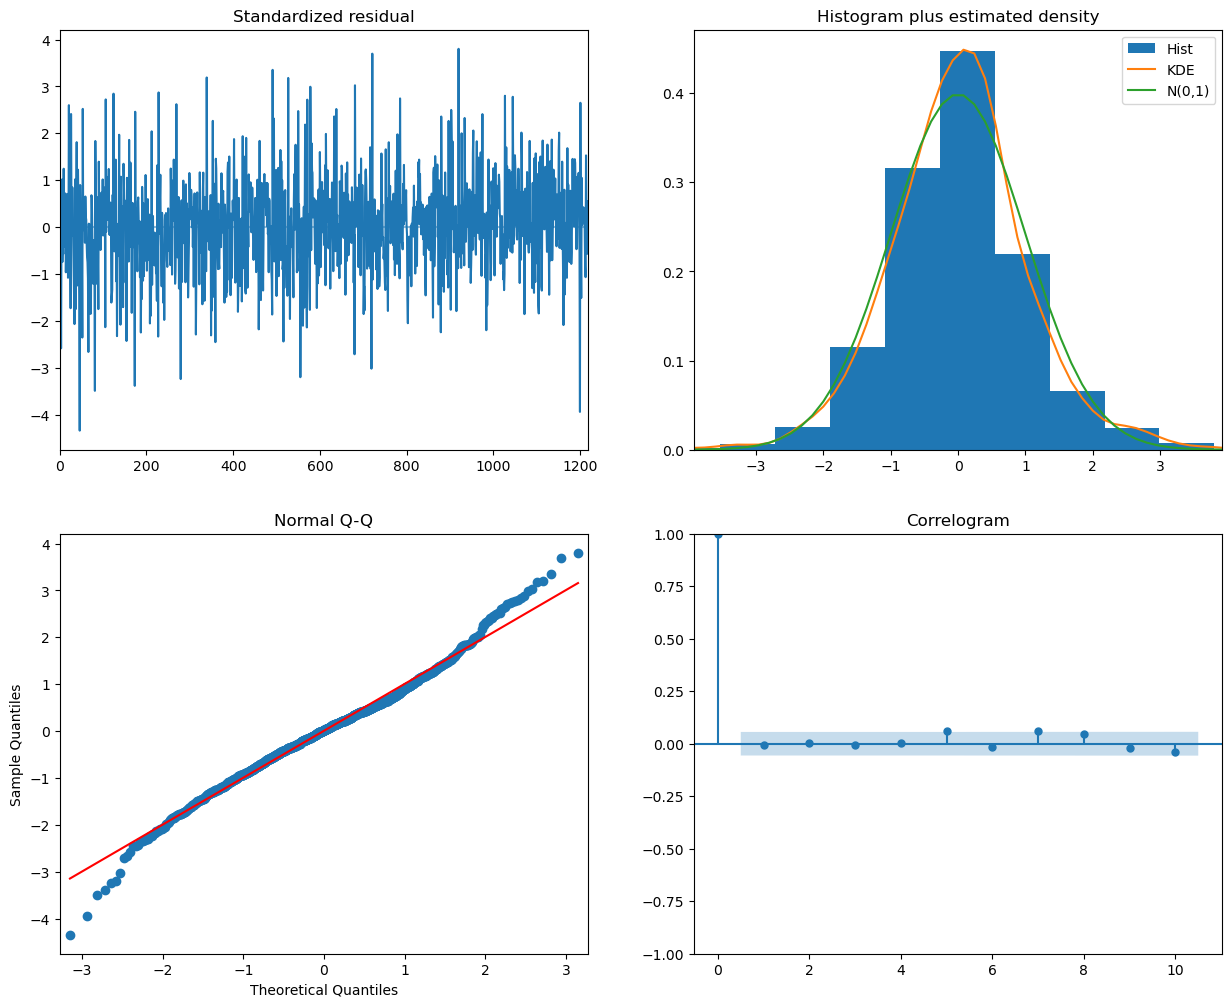

In [55]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [56]:
auto_model_fit = ARIMA_model.fit(y_train)

In [57]:
# Predict rainfall values for the remaining data points
y_pred_auto = auto_model_fit.predict(start=x_test.index[0], end=x_test.index[-1], typ='levels',n_periods=len(x_test))
print("Predictions:", y_pred_auto)

Predictions: 1220    5.230355
1221    5.281367
1222    5.174866
1223    5.139246
1224    5.195729
          ...   
1520    5.273174
1521    5.273174
1522    5.273174
1523    5.273174
1524    5.273174
Length: 305, dtype: float64


In [58]:
print("Length of x_test.index:", len(x_test))
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred_auto))

Length of x_test.index: 305
Length of y_test: 305
Length of y_pred: 305


In [59]:
# Create a DataFrame with x_test and y_pred values
df_pred_auto = pd.DataFrame({'Date': x_test, 'Actual': y_test, 'Predicted': y_pred_auto})
print(df_pred_auto)

           Date    Actual  Predicted
1220 2015-08-11  5.053473   5.230355
1221 2015-08-21  5.129641   5.281367
1222 2015-09-01  5.799224   5.174866
1223 2015-09-11  6.123255   5.139246
1224 2015-09-21  6.350355   5.195729
...         ...       ...        ...
1520 2024-01-11  5.400521   5.273174
1521 2024-01-21  5.206154   5.273174
1522 2024-02-01  4.004166   5.273174
1523 2024-02-11  3.850148   5.273174
1524 2024-02-21  3.717805   5.273174

[305 rows x 3 columns]


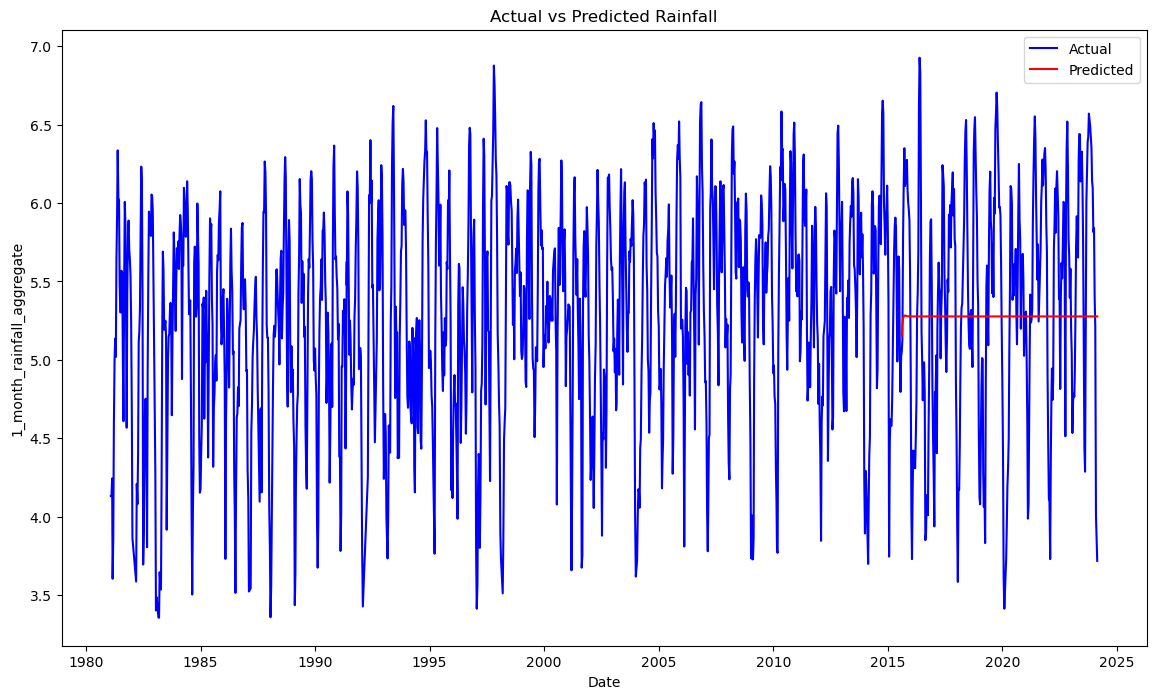

In [60]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], df['1_month_rainfall_aggregate'], label='Actual', color='blue')
plt.plot(df_pred_auto['Date'], df_pred['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('1_month_rainfall_aggregate')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.show()


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Evaluate Manual predtion 
mae = mean_absolute_error(y_test,forecast_test)
mape = mean_absolute_percentage_error(y_test,forecast_test)
mse = mean_squared_error(y_test,forecast_test)
rmse = np.sqrt(mean_squared_error(y_test,forecast_test))

print(f' mae - manual: {mae}' )
print(f' mape - manual: {mape}' )
print(f' mse - manual: {mse}' )
print(f' rmse - manual: {rmse}' )

 mae - manual: 0.6436589222386956
 mape - manual: 0.12410882651862676
 mse - manual: 0.592029443769727
 rmse - manual: 0.7694344960876962


In [72]:
# Manualy calculate the Error measures 
mae = np.mean(np.abs(y_test - forecast_test))
mse = np.mean((y_test - forecast_test) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast_test) / y_test)) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.6436589222386956
MAPE: 12.410882651862675%
MSE: 0.592029443769727
RMSE: 0.7694344960876962


In [73]:
# Evaluate automated prediction 
mae = mean_absolute_error(y_test,y_pred_auto)
mape = mean_absolute_percentage_error(y_test,y_pred_auto)
mse = mean_squared_error(y_test,y_pred_auto)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_auto))

print(f' mae - manual: {mae}' )
print(f' mape - manual: {mape}' )
print(f' mse - manual: {mse}' )
print(f' rmse - manual: {rmse}' )

 mae - manual: 0.6443693809299242
 mape - manual: 0.12414106716491453
 mse - manual: 0.5920630923605801
 rmse - manual: 0.7694563615700244


In [64]:
# Relatively mae,mape,rmse is low in the automated arima model therefore we use that model to predict the future values.

In [65]:
# Now, to "un-log" the values
predicted_values_unlogged = np.exp(forecast_test)
y_test_unlogged =  np.exp(y_test)

In [66]:
df_pred_auto_unlogged = pd.DataFrame({'Date': x_test, 'Actual': y_test_unlogged, 'Predicted': predicted_values_unlogged})
print(df_pred_auto_unlogged)

           Date    Actual   Predicted
1220 2015-08-11  156.5652  173.142517
1221 2015-08-21  168.9565  186.190708
1222 2015-09-01  330.0435  192.952734
1223 2015-09-11  456.3478  195.907410
1224 2015-09-21  572.6957  196.872644
...         ...       ...         ...
1520 2024-01-11  221.5217  195.821457
1521 2024-01-21  182.3913  195.821457
1522 2024-02-01   54.8261  195.821457
1523 2024-02-11   47.0000  195.821457
1524 2024-02-21   41.1739  195.821457

[305 rows x 3 columns]


# Predict the value

In [67]:
# Get the date from the user
user_date_str = input("Enter the date (YYYY-MM-DD): ")
user_date = pd.to_datetime(user_date_str)

Enter the date (YYYY-MM-DD):  2024-10-15


In [70]:
# Make predictions for the user-provided date
new_prediction = auto_model_fit.predict(start=user_date, end=user_date)

In [71]:
# Extract the predicted rainfall
if not new_prediction.empty:
    prediction_value = new_prediction.iloc[0]  # Extract the predicted value
    print("Predicted rainfall for", user_date.date(), ":", np.exp(prediction_value))
else:
    print("No prediction available for the given date.")

Predicted rainfall for 2024-10-15 : 186.85905927944998
